In [1]:
# import nltk
# nltk.download('wordnet')
# nltk.download('stopwords')

In [2]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
# from nltk.tokenize import TweetTokenizer
from nltk.tokenize.casual import reduce_lengthening
# from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from math import ceil
from sklearn.metrics import (f1_score, classification_report, 
                            confusion_matrix, accuracy_score, 
                            precision_score, recall_score, 
                            roc_auc_score, roc_curve)
from sklearn.preprocessing import label_binarize
from scipy.spatial.distance import cosine
import string
from math import log10, sqrt
from scipy.stats import norm
import re
import pickle
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

## Importing Tweet Data
***

In [3]:
columns = ['tweet_id','timestamp','tweet_text','user_id',
           'tweet_coords','tweet_coords_list','tweet_long','tweet_lat','location',
           'enc_url','tweet_lang','hashtags']
tweet_full = pd.read_csv(r'./tweetCoords.csv',
                         header=None,
                         names=columns,
                         parse_dates=[1],
                         infer_datetime_format=True,
                         index_col='timestamp')

In [4]:
related_words = pd.DataFrame()
tweet_date = pd.to_datetime("2017-09-10 00:00:00")
date_delta = pd.Timedelta("24HR")
end_date = pd.to_datetime("2017-09-10 00:00:00")

In [5]:
tweet_full_en = tweet_full[tweet_full['tweet_lang'] == 'en']

In [6]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]

## Helper Functions
***

In [7]:
tweet_stops = stopwords.words('english')
stemmer = PorterStemmer()

def clean_tweet(tweet):
##     takes input string and converts or removes characters depending on settings.
##     returns a string
##     convert case:
    tweet = tweet.lower()
##    remove URLs:
    tweet = re.sub('https?://\S+','',tweet)
##     remove @mentions, including those with a leading '-' or '.' : 
    tweet = re.sub('[-\.]?@\w+','',tweet)
##     remove non-hashtag punctuation:
#     tweet = tweet.translate(tweet.maketrans('','',string.punctuation.replace("#","")))
##     convert non-hashtag punctuation to whitespace:
    tweet = tweet.translate(tweet.maketrans(string.punctuation.replace("#","")," "*len(string.punctuation.replace("#",""))))
#     remove non-hashtag '#'.
    tweet = re.sub('\B#\B','',tweet)
##     remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
    tweet = re.sub(r'\b(amp|gt|lt)\b','',tweet)
##     drop numbers and words of < 4 characters.
#     tweet = re.sub(r'\b(?<!#)\w{1,3}\b','',tweet)
    tweet = re.sub(r'\b(?<!#)\d+\b','',tweet)
    return tweet

def tokens_no_stopwords(tweet_as_string):
#     wrapper function that combines the tokenizer, cleaner, and stopword removal.
#     takes a string and returns a list of strings
    cleaned_tweet = clean_tweet(tweet_as_string)
    tweet_reduce_len = reduce_lengthening(cleaned_tweet)
#     tweet_as_tokens = word_tokenize(tweet_reduce_len)
    tweet_as_tokens = tweet_reduce_len.split()
    tweet_no_stops = [stemmer.stem(word) for word in tweet_as_tokens if word not in tweet_stops]
    
    return tweet_no_stops

## Miscellaneous Tests:
***

In [8]:
punc_test = "This is some (&) text$that has &*char$ in it"
punc_test.translate(punc_test.maketrans(string.punctuation.replace("#","")," "*len(string.punctuation.replace("#",""))))

'This is some     text that has   char  in it'

In [9]:
punc_test.translate(punc_test.maketrans('','',string.punctuation.replace("#","")))

'This is some  textthat has char in it'

In [10]:
# tweet_tokenizer = TweetTokenizer(strip_handles=True,preserve_case=False,reduce_len=True)

In [11]:
re_hash_test = '# #34 4#3 A#36 3 A# #hashtag'
print(re.sub(r'\b#\B','!',re_hash_test))
print(re.sub(r'\b#\b','!',re_hash_test))
print(re.sub(r'\B#\B','!',re_hash_test))

# #34 4#3 A#36 3 A! #hashtag
# #34 4!3 A!36 3 A# #hashtag
! #34 4#3 A#36 3 A# #hashtag


In [12]:
text="this is a tweet # #### ####1 #hashtag #123 #12345 apm yooooo"
tokens_no_stopwords(text)

['tweet', '#1', '#hashtag', '#123', '#12345', 'apm', 'yooo']

## Word/Token Statistics
***

In [13]:
word_counts = tweet_text.str.split("\s+").apply(pd.Series).stack().value_counts()

In [14]:
word_counts.size

43387

In [15]:
# word_counts.head(20)

In [16]:
# word_counts.tail(20)

In [17]:
# tweet_reduce_len = TweetTokenizer(reduce_len=True)
word_counts_reduce = tweet_text.apply(reduce_lengthening).str.split().apply(pd.Series).stack().value_counts()

In [18]:
word_counts_reduce.size

43254

In [19]:
# np.setdiff1d(word_counts.index.values,word_counts_reduce.index.values)

In [20]:
# word_counts_reduce.head(20)

In [21]:
# word_counts_full_tokenizer = tweet_text.apply(tweet_tokenizer.tokenize).apply(pd.Series).stack().value_counts()

In [22]:
# word_counts_full_tokenizer.size

In [23]:
# word_counts_full_tokenizer.head(20)

In [24]:
tokenized_tweets = tweet_text.apply(tokens_no_stopwords)

In [25]:
# tweet_test = tweet_text.loc['2017-09-10 00:03:40'][1]
# print(tweet_test)
# tweet_test = tweet_test.lower()
# print(word_tokenize(tweet_test))
# print(tweet_test.split())
# i=0
# print(f"S: {tweet_test}");i+=1
# #     1: remove URLs:
# tweet_test = re.sub('https?://\S+','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     2: remove @mentions, including those with a leading '-' or '.' : 
# tweet_test = re.sub('[-\.]?@\w+','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     3: remove punctuation, but not hashtags:
# tweet_test = tweet_test.translate(tweet_test.maketrans('','',string.punctuation.replace("#","")))
# print(f"{i}: {tweet_test}");i+=1
# #     4: remove non-hashtag '#'.
# # tweet_test = re.sub('#\B','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     5: remove 'amp', 'gt', 'lt', indicating decoded ampersand, greater-than, less-than characters
# # tweet_test = re.sub(r'\b(amp|gt|lt)\b','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     6: drop words of < 4 characters, but not hashtags
# tweet_test = re.sub(r'\b(?<!#)\w{1,3}\b','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1
# #     7: drop numbers, but not hashtags
# tweet_test = re.sub(r'\b(?<!#)\d+\b','',tweet_test)
# print(f"{i}: {tweet_test}");i+=1

# print(word_tokenize(tweet_test))
# print(tokens_no_stopwords(tweet_test))

In [26]:
date_test = '2017-09-10 00:03:40'
print(tweet_text.loc[date_test].apply(reduce_lengthening))
print(tweet_text.loc[date_test].apply(tokens_no_stopwords))

timestamp
2017-09-10 00:03:40    #NaturalRemedies This Is the Only Product That...
2017-09-10 00:03:40    TAGGED 2017  #1 @ US 1-Biscayne Blvd. https://...
Name: tweet_text, dtype: object
timestamp
2017-09-10 00:03:40    [#naturalremedi, product, kill, virus, fungal,...
2017-09-10 00:03:40                         [tag, #1, us, biscayn, blvd]
Name: tweet_text, dtype: object


In [27]:
# tokenized_tweets[tokenized_tweets.apply(lambda x: '@' in x)]

In [28]:
word_counts_full_token_clean = tweet_text.apply(tokens_no_stopwords).apply(pd.Series).stack().value_counts()

In [29]:
word_counts_full_token_clean.size

14439

In [30]:
# word_counts_full_token_clean.head(20)

In [31]:
# word_counts_full_token_clean.tail(20)

In [32]:
tweet_len = tweet_text.groupby(tweet_text.str.split().apply(len)).size()

In [33]:
tweet_len_post = tweet_text.apply(tokens_no_stopwords).apply(len).value_counts().sort_index()

In [34]:
tweet_len_post[tweet_len_post.index <= 10].sum()

15971

In [35]:
tweet_len_post.sum()

19089

In [36]:
tweet_len

tweet_text
1       37
2      342
3      622
4      753
5      815
6      911
7      956
8     1052
9     1121
10    1022
11    1020
12    1040
13     988
14    1005
15    1308
16    1112
17     876
18     862
19     736
20     587
21     493
22     349
23     317
24     239
25     151
26     163
27      70
28      68
29      33
30      21
31      12
32       6
33       2
Name: tweet_text, dtype: int64

In [37]:
tweet_len_post

0       91
1      874
2     1402
3     1565
4     1745
5     1854
6     1800
7     1812
8     1865
9     1684
10    1279
11    1278
12     870
13     526
14     206
15     117
16      73
17      26
18      14
19       6
20       2
Name: tweet_text, dtype: int64

In [38]:
tweet_len_post[tweet_len_post.index < 11].sum()

15971

In [39]:
tweet_len_post[tweet_len_post.index < 11].sum()/tweet_len_post.sum()

0.8366598564618367

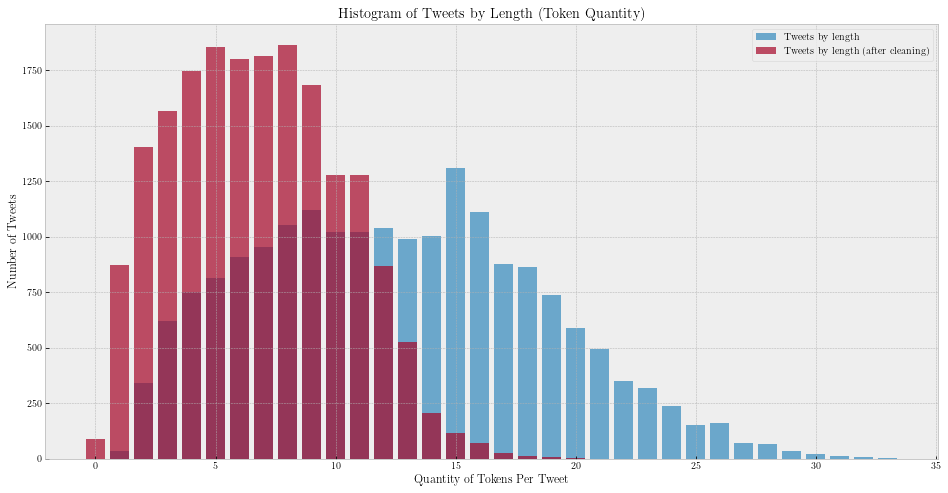

In [40]:
fig_tweet_hist = plt.figure(figsize=(16,8))
plt.style.use('bmh')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.bar(tweet_len.index,tweet_len.values,alpha=.7,label="Tweets by length")
plt.bar(tweet_len_post.index,tweet_len_post.values,alpha=.7,label="Tweets by length (after cleaning)")
plt.xlabel("Quantity of Tokens Per Tweet")
plt.ylabel("Number of Tweets")
plt.title("Histogram of Tweets by Length (Token Quantity)")
plt.legend()
plt.show()
fig_tweet_hist.savefig(f'./figures/TweetsByLength.pdf',bbox_inches='tight')

## Skip-Gram

### Search Term

In [41]:
search_term = 'irma'

### Window Size: 1-10

In [42]:
# comparison_type = "Min. Word Freq."
# comparison_short = "MinWordFreq"
comparison_type = "Window Size"
comparison_short = "WindowSize"

In [59]:
# eliminating the off-by-one error in the loop later. This will have a zero row, unfilled by vectors.
vectors_series = pd.Series(np.zeros((12)))

In [92]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)
for i in range(0,11):
    # ---------- Skip-Gram ----------
    # initialize the Word2Vec vectors with window size i, min count 1, and Skip-Gram
    vector_model = Word2Vec(tweets_tokens, seed=1, sg=1, min_count=i)#, window=8, workers=1, size=100, negative=i)
    
    # train the model over 10 epochs
    vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    
    # assign the vector data to its position in a series
    vectors_series.iloc[i] = vector_model

In [93]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

### Comparison Functions

Need a way to write the comparison functions with a larger function that calls them.

how about writing the functions as separate, with a larger function that calls the smaller functions with an argument.

- Mean Cosine Similarity
- Sum Cosine Similarity Over Square Root of Length
- Dot Product of Tweet As Matrix Sum of Term Vectors and Search Term
- Cosine Similarity of Tweet As Matrix Sum of Term Vectors and Search Term

In [94]:
def meanCosSim(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
    score = 0
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score += vector_set.wv.similarity(i,search_term)
    if len(tweet_as_terms) > 0:
        score /= len(tweet_as_terms)
    else:
        score = 0
    return score

In [95]:
def sumCosSimSqrtSum(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
    score = 0
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score += vector_set.wv.similarity(i,search_term)
    if len(tweet_as_terms) > 0:
        score /= sqrt(len(tweet_as_terms))
    else:
        score = 0
    return score

In [96]:
def dotProductOfTweetMatrixTermVector(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
#     initialize vector with dimensionality of the vector set.
    vector_dim = len(vector_set.wv.vectors[0])
    score_matrix = np.zeros(vector_dim,) 
#     iterate over each word after processing. If the word is in the vocabulary,
#     add its vector's value to the score matrix.
#     this essentially treats a word not in the vocabulary as a zero-vector.
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
#     if the number of words remaining in the tweet after processing is equal to zero, return zero.
#     otherwise, take the dot product of the score vector, and the vector of the search term.
    if len(tweet_as_terms) > 0:
        score = np.dot(score_matrix,vector_set.wv.get_vector(search_term))
    else:
        score = 0
    return score

In [141]:
def cosSimOfTweetMatrixTermVector(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
#     initialize vector with dimensionality of the vector set.
    vector_dim = len(vector_set.wv.vectors[0])
    score_matrix = np.zeros(vector_dim,) 
#     iterate over each word after processing. If the word is in the vocabulary,
#     add its vector's value to the score matrix.
#     this essentially treats a word not in the vocabulary as a zero-vector.
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
#     if the number of words remaining in the tweet after processing is equal to zero, return zero.
#     otherwise, take the pairwise cosine of the score vector and the vector of the search term.
    if (len(tweet_as_terms) > 0 & score_matrix == np.zeros(vector_dim,)):
        score = 1 - cosine(score_matrix,vector_set.wv.get_vector(search_term))
    else:
        score = 0
    return score

Wrapper Function for the scalar comparison formulas:

In [98]:
def scalarFunctions(tweet,vector_set,formula='dp'):
    if(formula.upper() == 'DP'):
        return dotProductOfTweetMatrixTermVector(tweet,vector_set)
    elif(formula.upper() == 'MCS'):
        return meanCosSim(tweet,vector_set)
    elif(formula.upper() == 'SCSSC'):
        return sumCosSimSqrtSum(tweet,vector_set)
    elif(formula.upper() == 'CSTVS'):
        return cosSimOfTweetMatrixTermVector(tweet,vector_set)
    else:
        return np.NaN

In [99]:
scalarFunctions(tweets_on_date.iloc[0,1],vectors_series[1],'mcs')

0.308527010679245

In [100]:
# func_type = "Mean Cosine Similarity"
# func_short = "MeanCosSim"
# def ScoreTweetFromVectors(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
#     score = 0
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score += vector_set.wv.similarity(i,search_term)
#     if len(tweet_as_terms) > 0:
#         score /= len(tweet_as_terms)
#     else:
#         score = 0
#     return score

In [101]:
# from math import sqrt
# func_type = "Sum Score over Sqrt Cos. Sim."
# func_short = "SumOverSqrtLen"
# def ScoreTweetFromVectors(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
#     score = 0
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score += vector_set.wv.similarity(i,search_term)
#     if len(tweet_as_terms) > 0:
#         score /= sqrt(len(tweet_as_terms))
#     else:
#         score = 0
#     return score

In [102]:
func_type = "Dot Product of Tweet Vector and Search Term"
func_short = "DotProduct"
def ScoreTweetFromVectors(tweet,vector_set):
    tweet_as_terms = tokens_no_stopwords(tweet)
#     initialize vector with dimensionality of the vector set.
    vector_dim = len(vector_set.wv.vectors[0])
    score_matrix = np.zeros(vector_dim,) 
#     iterate over each word after processing. If the word is in the vocabulary,
#     add its vector's value to the score matrix.
#     this essentially treats a word not in the vocabulary as a zero-vector.
    for i in tweet_as_terms:
        if i in vector_set.wv.vocab:
            score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
#     if the number of words remaining in the tweet after processing is equal to zero, return zero.
#     otherwise, take the dot product of the score vector, and the vector of the search term.
    if len(tweet_as_terms) > 0:
        score = np.dot(score_matrix,vector_set.wv.get_vector(search_term))
    else:
        score = 0
    return score

In [103]:
# func_type = "Cosine Similarity of Tweet Vector Sum and Search Term"
# func_short = "CosSimTweetVecSum"
# def ScoreTweetFromVectorsCSTVS(tweet,vector_set):
#     tweet_as_terms = tokens_no_stopwords(tweet)
# #     initialize vector with dimensionality of the vector set.
#     vector_dim = len(vector_set.wv.vectors[0])
#     score_matrix = np.zeros(vector_dim,) 
# #     iterate over each word after processing. If the word is in the vocabulary,
# #     add its vector's value to the score matrix.
# #     this essentially treats a word not in the vocabulary as a zero-vector.
#     for i in tweet_as_terms:
#         if i in vector_set.wv.vocab:
#             score_matrix = np.add(score_matrix,vector_set.wv.get_vector(i))
# #     if the number of words remaining in the tweet after processing is equal to zero, return zero.
# #     otherwise, take the pairwise cosine of the score vector and the vector of the search term.
#     if len(tweet_as_terms) > 0:
#         score = 1 - cosine(score_matrix,vector_set.wv.get_vector(search_term))
#     else:
#         score = 0
#     return score

In [104]:
tweet_encoded.iloc[0:5].tweet_text.apply(scalarFunctions,args=(vectors_series.iloc[1],'mcs'))

0    0.308527
1    0.486194
2    0.458575
3    0.479357
4    0.443724
Name: tweet_text, dtype: float64

In [117]:
for i in range(0,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(vectors_series.iloc[i],'cstvs'))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [115]:
vectors_series.iloc[1].wv.similar_by_word("irma", topn=10, restrict_vocab=None)

[('directli', 0.7046617269515991),
 ('devast', 0.7043446898460388),
 ('downgrad', 0.7043063640594482),
 ('project', 0.7042182683944702),
 ('shortli', 0.7009667158126831),
 ('standbi', 0.7001546621322632),
 ('slightli', 0.6958099007606506),
 ('impact', 0.6875610947608948),
 ('slam', 0.685063898563385),
 ('pass', 0.6844182014465332)]

In [140]:
score_matrix = np.zeros(100,)
cosine(score_matrix,vectors_series.iloc[2].wv.get_vector('irma') )

nan

In [135]:
scalarFunctions('THE FFUCK IS THIS https://t.co/LVhxRyLxvc',vectors_series.iloc[2],'cstvs')

nan

In [124]:
tweet_encoded[['tweet_text','score_window_2']]

,tweet_text,score_window_2
0,"Wind 2.0 mph N. Barometer 29.880 in, Steady. T...",0.326715
1,There is always beauty regardless the circumst...,0.536693
2,#Carpool #Orlando - gt #Orlando #KIrkmanRoad ...,0.518305
3,@avictoria_x nah i m chillin my eyes never get...,0.549800
4,@jvnvy @sza That s how I feel bout seein travis,0.401743
5,Taking a beak from boarding the windows. Kitty...,0.557232
6,"19:53 Temp. 82.4 F, Hum. 79 , Dewp. 73.6 F, Ba...",0.307200
7,"I m so proud of our local radio, news, animal ...",0.527987
8,Evening of a Hurricane. #hurricane #hurricanei...,0.530104
9,hey big head https://t.co/M46uNJoxx2,0.536493


In [118]:
for i in range(0,11):
    print(round(roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}']),3))

0.736
0.733


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

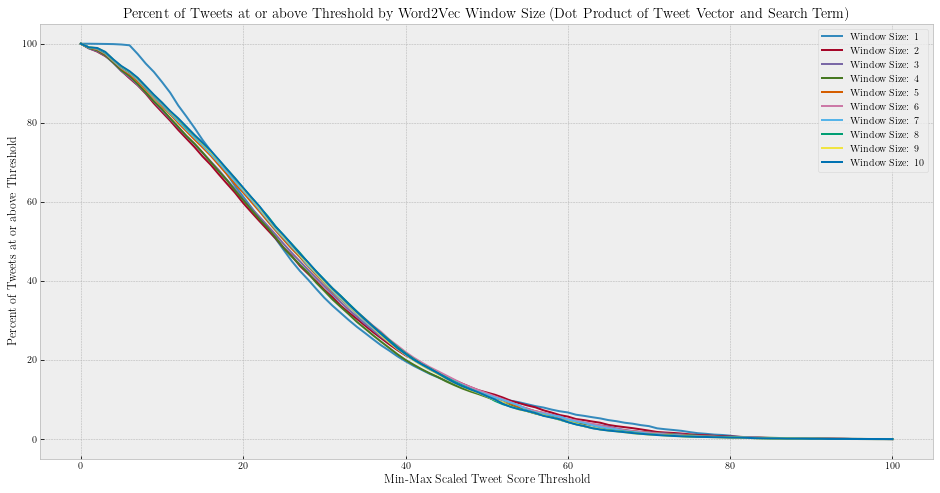

In [60]:
fig_0 = plt.figure(figsize=(16,8),facecolor='w')

for j in range(1,11):
    window_label = f"{comparison_type}: {j}"
    plt.plot(range(101),[100*len(tweet_encoded[tweet_encoded[f'MM_score_window_{j}'] > i])/len(tweet_encoded) for i in range(101)],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("Percent of Tweets at or above Threshold")
plt.title(f"Percent of Tweets at or above Threshold by Word2Vec {comparison_type} ({func_type})")
plt.legend();

# fig_0.savefig(f'./figures/{comparison_short}{func_short}PercentTweetsBelow.pdf',bbox_inches='tight')

### F1 Score Comparisons

In [61]:
f1_window_score_df = pd.DataFrame(np.zeros((101,11)))
pre_score_df = pd.DataFrame(np.zeros((101,11)))
rec_score_df = pd.DataFrame(np.zeros((101,11)))

In [62]:
for i in range(1,11):
    for j in range(101):
        f1_window_score_df.iloc[j,i] = f1_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        pre_score_df.iloc[j,i] = precision_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        rec_score_df.iloc[j,i] = recall_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)

/Users/brown/.local/share/virtualenvs/TwitterDisaster-4Cppn-LV/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/brown/.local/share/virtualenvs/TwitterDisaster-4Cppn-LV/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [63]:
print(pd.concat([f1_window_score_df.idxmax(),f1_window_score_df.max()],axis=1,names=['TweetScore','F1Score']))
print(f1_window_score_df.idxmax().max())
print(f1_window_score_df.max().max())

     0         1
0    0  0.000000
1   22  0.746229
2   21  0.728094
3   21  0.724166
4   21  0.722222
5   22  0.723437
6   22  0.720506
7   22  0.720520
8   22  0.718474
9   23  0.717057
10  23  0.720181
23
0.7462293007066765


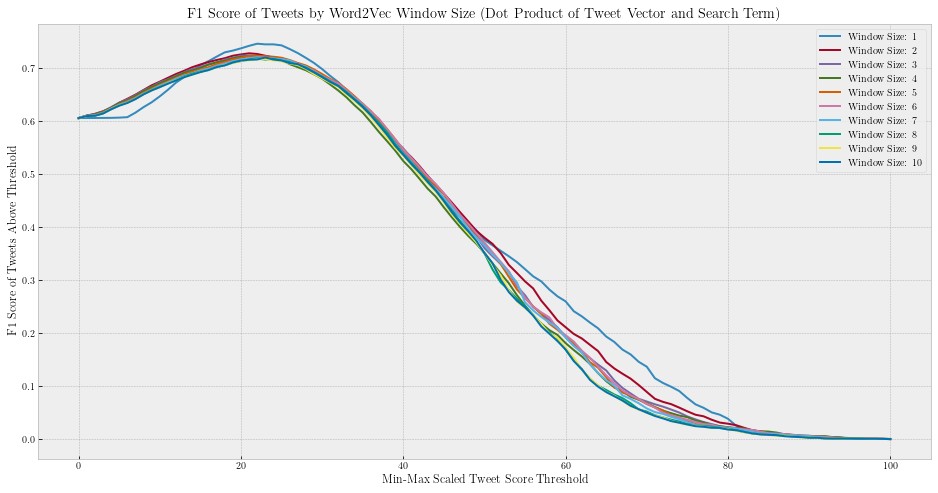

In [64]:
fig_1 = plt.figure(figsize=(16,8),facecolor='w')
for i in range(1,11):
    plt.plot(f1_window_score_df.iloc[:,i],label=f"{comparison_type}: {i}")
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("F1 Score of Tweets Above Threshold")
plt.title(f"F1 Score of Tweets by Word2Vec {comparison_type} ({func_type})")
plt.legend();
# fig_1.savefig(f'./figures/{comparison_short}{func_short}F1Score.pdf',bbox_inches='tight')

### Hidden Layer Dimensionality (window size 7)

In [65]:
comparison_type = "Hidden Layer Dimensionality"
comparison_short = "HLD"

In [66]:
# eliminating the off-by-one error in the loop later. This will have a zero row, unfilled by vectors.
vectors_series = pd.Series(np.zeros((11)))

In [67]:
# %%timeit
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)
# for i in range(1,11):
#     hidden_layer_dim = 50*i
#     # ---------- Skip-Gram ----------
#     # initialize the Word2Vec vectors with window size 8, min count 1, and Skip-Gram (Hidden Layer Dim. Test)
#     vector_model = Word2Vec(tweets_tokens, min_count=1, window=8, workers=1, size=hidden_layer_dim, seed=1, sg=1, negative=5)
    
#     # train the model over 10 epochs
#     vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    
#     # assign the vector data to its position in a series
#     vectors_series.iloc[i] = vector_model

## 2min 29s ± 544 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [68]:
# %%timeit
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)

# opt_vector_model = Word2Vec(tweets_tokens, min_count=1, window=8, workers=1, size=150, seed=1, sg=1, negative=1)
    
# # train the model over 10 epochs
# opt_vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
## 6.67 s ± 42.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [69]:
# %%timeit
# tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
# tweets_tokens = tweet_text.apply(tokens_no_stopwords)

# opt_vector_model = Word2Vec(tweets_tokens, min_count=1, window=8, workers=1, size=150, seed=1, sg=1, negative=1)
    
# # train the model over 10 epochs
# opt_vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=50)
## 16.1 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [70]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)

opt_vector_model = Word2Vec(tweets_tokens, min_count=1, window=8, workers=1, size=150, seed=1, sg=1, negative=1)
    
# train the model over 10 epochs
opt_vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)

(1181282, 1289640)

In [107]:
opt_vector_model.wv.get_vector('irma')

array([ 0.05583398, -0.16964225, -0.24978063, -0.5116523 , -0.04886265,
       -0.03259129, -0.01309117,  0.28682345,  0.16617066,  0.08423751,
       -0.12915827,  0.1045065 , -0.10562009,  0.24263953,  0.10590621,
       -0.03680001, -0.1418977 , -0.12057551, -0.14878431,  0.10871943,
       -0.28139728,  0.17550819,  0.25419143, -0.02224697, -0.00722718,
       -0.05943703,  0.1460032 , -0.17010221,  0.14582682,  0.11589276,
       -0.00177217, -0.10109309, -0.13494894, -0.16322777,  0.1153229 ,
        0.36417124, -0.19318269, -0.07805439, -0.06790753, -0.44774443,
        0.02776827,  0.19366379, -0.25336143, -0.08880188, -0.14135316,
       -0.32393342, -0.09729595,  0.19595538,  0.26233196,  0.03616119,
        0.01935313, -0.2379273 ,  0.09911886, -0.01100178, -0.18750328,
        0.30541968,  0.1956325 ,  0.10614002, -0.23730296, -0.04804969,
        0.34881654, -0.1318759 ,  0.07637101, -0.15317091,  0.3269045 ,
       -0.17901777, -0.15399389,  0.24402903, -0.12735437, -0.01

### AU-ROC Score

In [71]:
for i in ['dp','mcs','scssc','cstvs']:
#     create strings for column heads
    sw = f'sw_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(opt_vector_model,i))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [72]:
tweet_encoded.head()

,index,irma_rel,tweet,timestamp,tweet_id,tweet_text,user_id,tweet_coords,tweet_coords_list,tweet_long,...,score_window_10,MM_score_window_10,sw_dp,MM_sw_dp,sw_mcs,MM_sw_mcs,sw_scssc,MM_sw_scssc,sw_cstvs,MM_sw_cstvs
0,0,1,"Wind 2.0 mph N. Barometer 29.880 in, Steady. T...",2017-09-10 00:00:01,906668545542680576,"Wind 2.0 mph N. Barometer 29.880 in, Steady. T...",1227982520,"[28.87527778,-81.2525]","[[[-81.285896, 28.84511], [-81.285896, 28.9640...",-81.2525,...,55.744161,50.061697,30.064465,56.489432,0.250399,50.965790,0.791831,57.597276,0.316280,55.275330
1,1,0,There is always beauty regardless the circumst...,2017-09-10 00:00:03,906668555185291265,There is always beauty regardless the circumst...,42239064,"[29.5381,-81.2234]","[[[-81.279617, 29.424649], [-81.279617, 29.627...",-81.2234,...,34.676610,31.146749,15.495239,32.381678,0.422990,62.255624,1.119127,66.888369,0.620471,75.173597
2,2,0,#Carpool #Orlando - gt #Orlando #KIrkmanRoad ...,2017-09-10 00:00:03,906668556493889536,#Carpool #Orlando - gt #Orlando #KIrkmanRoad ...,87188071,"[28.4363045,-81.4797168]","[[[-87.634643, 24.396308], [-87.634643, 31.001...",-81.4797,...,32.634242,29.313062,9.586555,22.604555,0.328686,56.086848,0.986059,63.110899,0.552125,70.702838
3,3,0,@avictoria_x nah i m chillin my eyes never get...,2017-09-10 00:00:06,906668570079309830,@avictoria_x nah i m chillin my eyes never get...,746764728,NaN,"[[[-81.25235, 28.549308], [-81.25235, 28.58224...",-81.2380,...,24.036231,21.593564,9.504491,22.468763,0.373415,59.012695,0.914675,61.084499,0.604334,74.117975
4,4,0,@jvnvy @sza That s how I feel bout seein travis,2017-09-10 00:00:08,906668576056246278,@jvnvy @sza That s how I feel bout seein travis,1679199278,NaN,"[[[-82.31457, 27.823335], [-82.31457, 27.85374...",-82.2877,...,12.030672,10.814688,2.966316,11.650021,0.169239,45.656791,0.338478,44.727702,0.337193,56.643318


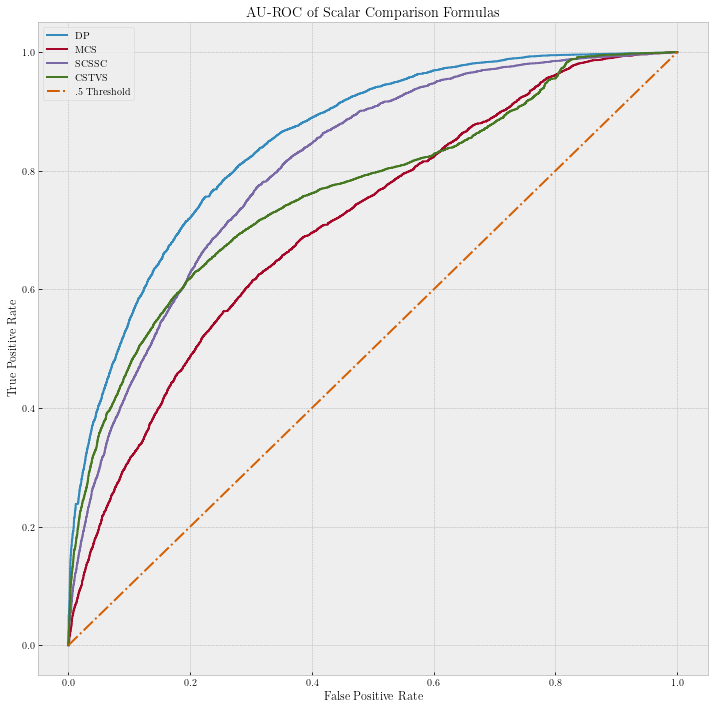

In [73]:
fig_roc_s = plt.figure(figsize=(12,12),facecolor='w')
for i in ['dp','mcs','scssc','cstvs']:
    fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded[f'MM_sw_{i}'])
    plt.plot(fpr,tpr,label=i.upper())
plt.plot([0,1],[0,1],linestyle="-.",label=".5 Threshold")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AU-ROC of Scalar Comparison Formulas")
plt.legend()
plt.show()
fig_roc_s.savefig(f'./figures/scalar_roc_curve.pdf',bbox_inches='tight')

### Related Words by 1 Hour Increments

In [99]:
related_words = pd.DataFrame()
tweet_date = pd.to_datetime("2017-09-10 00:00:00")
date_delta = pd.Timedelta("1HR")
end_date = pd.to_datetime("2017-09-11 00:00:00")
top_num_words = 20
search_term = 'irma'

In [100]:
for tweet_day in pd.date_range(start = tweet_date, end = end_date, freq = date_delta):
    tweet_text = tweet_full_en.loc[tweet_day:tweet_day + date_delta,"tweet_text"]
    tweets_tokens = tweet_text.apply(tokens_no_stopwords)
    opt_vector_model_1hr = Word2Vec(tweets_tokens, min_count=1, window=8, workers=1, size=150, seed=1, sg=1, negative=1)
    opt_vector_model_1hr.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    opt_word_matrix_1hr = opt_vector_model_1hr.wv[opt_vector_model_1hr.wv.vocab]
    terms_from_range = pd.DataFrame.from_records(opt_vector_model_1hr.wv.most_similar(search_term,topn=top_num_words),columns=[tweet_day,"Cos_Sim"])
    related_words = pd.concat([related_words,terms_from_range],axis=1)

In [106]:
related_words.iloc[:,0::2].to_csv('./top_words_no_scores.csv')

### Network Graphs

In [175]:
# token_counts = tweets_tokens.apply(pd.Series).stack().value_counts()

In [ ]:
# from itertools import combinations
# word_pairs = list(combinations(list(vector_model.wv.vocab.keys()),2))
# tweet_graph = nx.Graph()
# for word_count in token_counts.iteritems():
#     tweet_graph.add_node(word_count[0],count=word_count[1])
# for pair in word_pairs:
#     edge_weight = vector_model.wv.similarity(pair[0],pair[1])
#     if edge_weight > .80:
#         tweet_graph.add_edge(pair[0],pair[1],weight=edge_weight)
# nx.write_gexf(tweet_graph,path=r'./tweet_graph.gexf')

In [186]:
# num_words = 10
# tweet_graph = nx.Graph()
# for word_count in token_counts.iteritems():
#     tweet_graph.add_node(word_count[0],count=word_count[1])
# for word in list(opt_vector_model.wv.vocab.keys()):
#     word_scores = opt_vector_model.wv.most_similar(word, topn=num_words)
#     for i in range(num_words):
#         tweet_graph.add_edge(word,word_scores[i][0],weight=word_scores[i][1])
# nx.write_gexf(tweet_graph,path=f'./tweet_graph_{num_words}.gexf')

In [207]:
for i in range(1,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(scalarFunctions,args=(vectors_series.iloc[i],'scssc'))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [208]:
for i in range(1,11):
    print(round(roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}']),3))

0.779
0.784
0.784
0.781
0.779
0.779
0.777
0.777
0.776
0.775


In [ ]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

In [ ]:
for i in range(1,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(ScoreTweetFromVectors,args=(vectors_series.iloc[i],))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [ ]:
fig_hld_1 = plt.figure(figsize=(16,8),facecolor='w')

for j in range(1,11):
    window_label = f"{comparison_type}: {25*j + 25}"
    plt.plot(range(101),[len(tweet_encoded[tweet_encoded[f'MM_score_window_{j}'] > i])/len(tweet_encoded) for i in range(101)],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("Percent of Tweets at or Above Threshold")
plt.title(f"Percent of Tweets at or Above Threshold by Word2Vec {comparison_type} ({func_type})")
plt.legend();

# fig_hld_1.savefig(f'./figures/{comparison_short}{func_short}PercentTweetsBelow.pdf',bbox_inches='tight')

### F1 Score Comparisons

In [ ]:
f1_window_score_df = pd.DataFrame(np.zeros((101,11)))
pre_score_df = pd.DataFrame(np.zeros((101,11)))
rec_score_df = pd.DataFrame(np.zeros((101,11)))

In [ ]:
for i in range(1,11):
    for j in range(101):
        f1_window_score_df.iloc[j,i] = f1_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        pre_score_df.iloc[j,i] = precision_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        rec_score_df.iloc[j,i] = recall_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)

In [ ]:
print(pd.concat([f1_window_score_df.idxmax(),f1_window_score_df.max()],axis=1,names=['TweetScore','F1Score']))
print(f1_window_score_df.idxmax().max())
print(f1_window_score_df.max().max())

In [ ]:
fig_hld_2 = plt.figure(figsize=(16,8),facecolor='w')
for i in range(1,11):
    window_label = f"{comparison_type}: {25*i + 25}"
    plt.plot(f1_window_score_df.iloc[:,i],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("F1 Score of Tweets Above Threshold")
plt.title(f"F1 Score of Tweets by Word2Vec {comparison_type} ({func_type})")
plt.legend();
# fig_hld_2.savefig(f'./figures/{comparison_short}{func_short}F1Score.pdf',bbox_inches='tight')

### Negative Sampling (window size 7, dim = 100)

In [ ]:
comparison_type = "Negative Sampling Test"
comparison_short = "NS"

In [ ]:
# eliminating the off-by-one error in the loop later. This will have a zero row, unfilled by vectors.
vectors_series = pd.Series(np.zeros((11)))

In [ ]:
tweet_text = tweet_full_en.loc[tweet_date:tweet_date + date_delta,"tweet_text"]
tweets_tokens = tweet_text.apply(tokens_no_stopwords)
for i in range(0,11):
    ns_size = i
    # ---------- Skip-Gram ----------
    # initialize the Word2Vec vectors with window size 7, min count 1, and Skip-Gram (Negative Sampling Test)
    vector_model = Word2Vec(tweets_tokens, min_count=1, window=7, workers=1, size=100, seed=1, sg=1, negative=ns_size)
    
    # train the model over 10 epochs
    vector_model.train(tweets_tokens, total_examples=len(tweet_text), epochs=10)
    
    # assign the vector data to its position in a series
    vectors_series.iloc[i] = vector_model

In [ ]:
coded_tweets = pd.read_csv(r'./irma_related_tweets.csv')

tweets_on_date = tweet_full_en.loc[tweet_date:tweet_date+date_delta]

tweet_encoded = pd.concat([coded_tweets.reset_index(),tweets_on_date.iloc[:-1].reset_index()],axis=1)

In [ ]:
vectors_series

In [ ]:
for i in range(0,11):
#     create strings for column heads
    sw = f'score_window_{i}'
    mmsw = f'MM_{sw}'
    
#     Scoring tweets in this column:
    tweet_encoded[sw] = tweet_encoded.tweet_text.apply(ScoreTweetFromVectors,args=(vectors_series.iloc[i],))
                                                       
#     column of scores for this iteration
    tweet_scores = tweet_encoded[sw]

#     calculating Min Max Scaling for this column 
    tweet_encoded[mmsw] = ((tweet_scores - tweet_scores.min())* 100) / (tweet_scores.max() - tweet_scores.min())

In [ ]:
fig_roc_1 = plt.figure(figsize=(12,12),facecolor='w')
for i in range(1,2):
    fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}'])
    plt.plot(fpr,tpr,label=f"Negative Sample Test: {i}")
plt.plot([0,1],[0,1],linestyle="-.",label=".5 Threshold")
plt.legend()
plt.show()
# fig_roc_1.savefig(f'./figures/neg_samp_size_1-10_roc_curve.pdf',bbox_inches='tight')

In [ ]:
fig_ns_1 = plt.figure(figsize=(16,8),facecolor='w')

for j in range(0,11):
    window_label = f"{comparison_type}: {j}"
    plt.plot(range(101),[100 * len(tweet_encoded[tweet_encoded[f'MM_score_window_{j}'] > i])/len(tweet_encoded) for i in range(101)],label=window_label)
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("Percent of Tweets Above Threshold")
plt.title(f"Percent of Tweets Above Threshold by Word2Vec {comparison_type} ({func_type})")
plt.legend();

#fig_ns_1.savefig(f'./figures/{comparison_short}{func_short}PercentTweetsBelow.pdf',bbox_inches='tight')

In [ ]:
from scipy.stats import norm
print(np.linspace(1,100,100))
#norm.cdf(tweet_encoded['MM_score_window_1'],np.linspace(1,100,100))

In [ ]:
plt.hist(tweet_encoded['MM_score_window_1'].values,bins=100)

### F1 Score Comparisons

In [ ]:
f1_window_score_df = pd.DataFrame(np.zeros((101,11)))
pre_score_df = pd.DataFrame(np.zeros((101,11)))
rec_score_df = pd.DataFrame(np.zeros((101,11)))

In [ ]:
for i in range(0,11):
    for j in range(101):
        f1_window_score_df.iloc[j,i] = f1_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        pre_score_df.iloc[j,i] = precision_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)
        rec_score_df.iloc[j,i] = recall_score(tweet_encoded.irma_rel,tweet_encoded[f'MM_score_window_{i}'] > j)

In [ ]:
ns_test = pd.DataFrame(pd.concat([f1_window_score_df.idxmax().rename('MM_Score'),f1_window_score_df.max().rename('F1_Score_Max')],axis=1))
ns_test['Neg_Samp_Size'] = pd.Series(range(0,11))

In [ ]:
ns_test[['Neg_Samp_Size','MM_Score','F1_Score_Max']]

In [ ]:
print(f1_window_score_df.idxmax().max())
print(f1_window_score_df.max().idxmax())

In [ ]:
fig_ns_2 = plt.figure(figsize=(16,8),facecolor='w')
for i in range(0,11):
    if i == f1_window_score_df.max().idxmax():
        plt.plot(f1_window_score_df.iloc[:,i],label=f"{comparison_type}: {i} (F1 Max)",linestyle=":")
    else:
        plt.plot(f1_window_score_df.iloc[:,i],label=f"{comparison_type}: {i}")
plt.xlabel("Min-Max Scaled Tweet Score Threshold")
plt.ylabel("F1 Score of Tweets Above Threshold")
plt.title(f"F1 Score of Tweets by Word2Vec {comparison_type} ({func_type})")
plt.legend();
# fig_ns_2.savefig(f'./figures/neg_samp_size_1-10_F1Score.pdf',bbox_inches='tight')

In [ ]:
tweet_to_score = tweet_full[tweet_full.tweet_text.str.contains('will post again')].tweet_text[0]

ScoreTweetFromVectors(tweet_to_score,vector_set=vectors_series.iloc[1])
# print(type(tweet_to_score))
# print(tweet_to_score)

In [ ]:
print(tweet_to_score)

In [ ]:
tweet_encoded[(tweet_encoded['score_window_1'] > 22.85) & (tweet_encoded['score_window_1'] < 22.88)]['MM_score_window_1']

In [49]:
roc_auc_score(tweet_encoded['irma_rel'],tweet_encoded['MM_score_window_1'])

0.813429069570445

In [50]:
fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded['MM_score_window_1'])

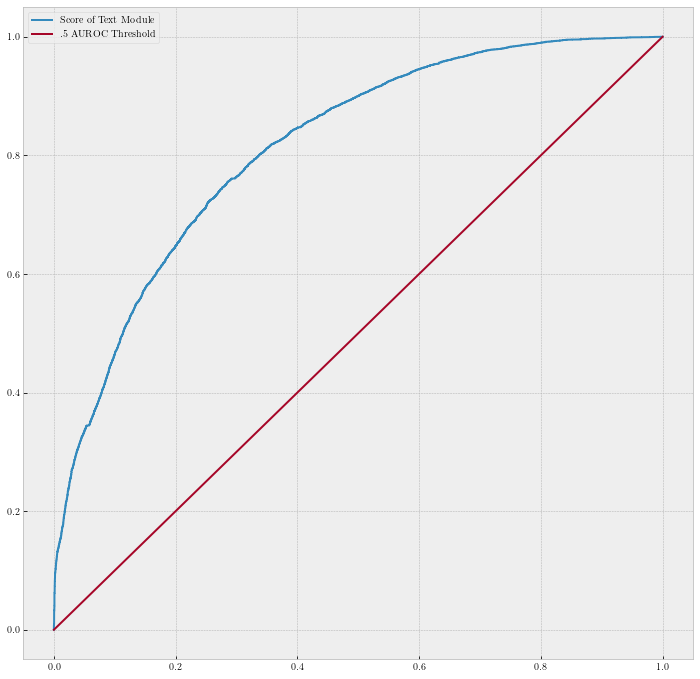

In [51]:
fig_roc_1 = plt.figure(figsize=(12,12),facecolor='w')
plt.plot(fpr,tpr,label='Score of Text Module')
plt.plot([0,1],[0,1],label='.5 AUROC Threshold')
plt.legend()
plt.show()
# fig_roc_1.savefig(f'./figures/text_mod_roc_curve.pdf',bbox_inches='tight')

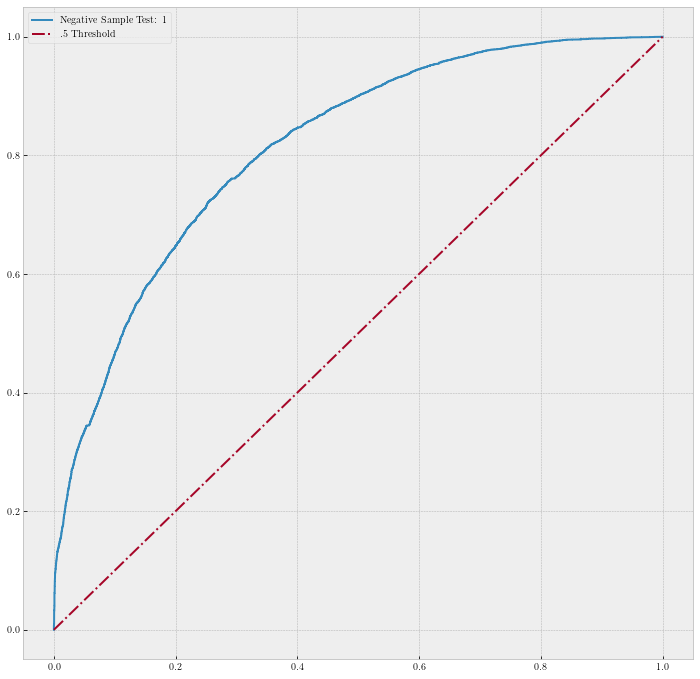

In [52]:
fig_roc_1 = plt.figure(figsize=(12,12),facecolor='w')
for i in range(1,2):
    fpr, tpr, thresholds = roc_curve(tweet_encoded['irma_rel'],tweet_encoded[f'MM_score_window_{i}'])
    plt.plot(fpr,tpr,label=f"Negative Sample Test: {i}")
plt.plot([0,1],[0,1],linestyle="-.",label=".5 Threshold")
plt.legend()
plt.show()
# fig_roc_1.savefig(f'./figures/neg_samp_size_1-10_roc_curve.pdf',bbox_inches='tight')